# Fantasy Premier League

## Chip Strategy

Chips are bonuses to use once per gameweek. The **Wildcard** allows you to make unlimited transfer for a week. The **Freehit** allows to make unlimited transfers (temporary for a single GW). The **Bench Boost** gives you the points scored by yout benched players. The **Triple Captain** triples the points of yout captain instead of double.

In this notebook, we will study the chip strategy of top managers from the 2020-2021 FPL Season.

In [1]:
import pandas as pd
import numpy as np

# Get fixtures
fixtures = pd.read_csv("../data/fpl_official/vaastav/data/2020-21/fixtures.csv")[['event', 'team_a', 'team_h']]

gw_type = {}
for gw in range(1, 39):
    if fixtures[fixtures['event'] == gw].shape[0] < 10:
        gw_type[gw] = 'BGW'
    elif fixtures[fixtures['event'] == gw].shape[0] > 10:
        gw_type[gw] = 'DGW'
    else :
        # Handle dgw for some & bgw for others
        playing_teams = list(fixtures[fixtures['event'] == 1]['team_a'].values) + list(fixtures[fixtures['event'] == 1]['team_h'].values)
        if np.all([team_id in playing_teams for team_id in np.arange(1, 20)]):
            gw_type[gw] = 'Mixed'
        else:
            gw_type[gw] = 'Vanilla'

In [2]:
import glob
import os

path = '../data/fpl_official/20-21/season/raw/'
all_managers = (
    glob.glob(os.path.join(path, "managers_[0-9][0-9][0-9][0-9][0-9].json")) + 
    glob.glob(os.path.join(path, "managers_[0-9][0-9][0-9][0-9].json")) + 
    glob.glob(os.path.join(path, "managers_100000.json"))
)

In [3]:
chips = (
    pd.DataFrame(
        list(pd.read_json(f, orient='index')['chips']),
        columns=['wildcard_1', 'freehit', 'bboost', 'wildcard_2', 'threexc'],
        index=pd.read_json(f, orient='index').index
        )
    for f in all_managers
    )

chips = pd.concat(chips)

In [4]:
# Change index type & Sort index
chips.drop('[]', inplace=True, errors='ignore')
chips.index = chips.index.map(int)
chips.sort_index(inplace=True)

In [5]:
chips = chips.fillna(0)
chips = chips.astype(int)
# Handle the cases when managers have only used their second Wildcard.
chips.loc[(chips['wildcard_2'] == 0) & (chips['wildcard_1'] > 16), 'wildcard_2'] = chips[chips['wildcard_2'] == 0]['wildcard_1']
chips.loc[(chips['wildcard_1'] == chips['wildcard_2']) & (chips['wildcard_1'] > 16), 'wildcard_1'] = 0

### Distribution

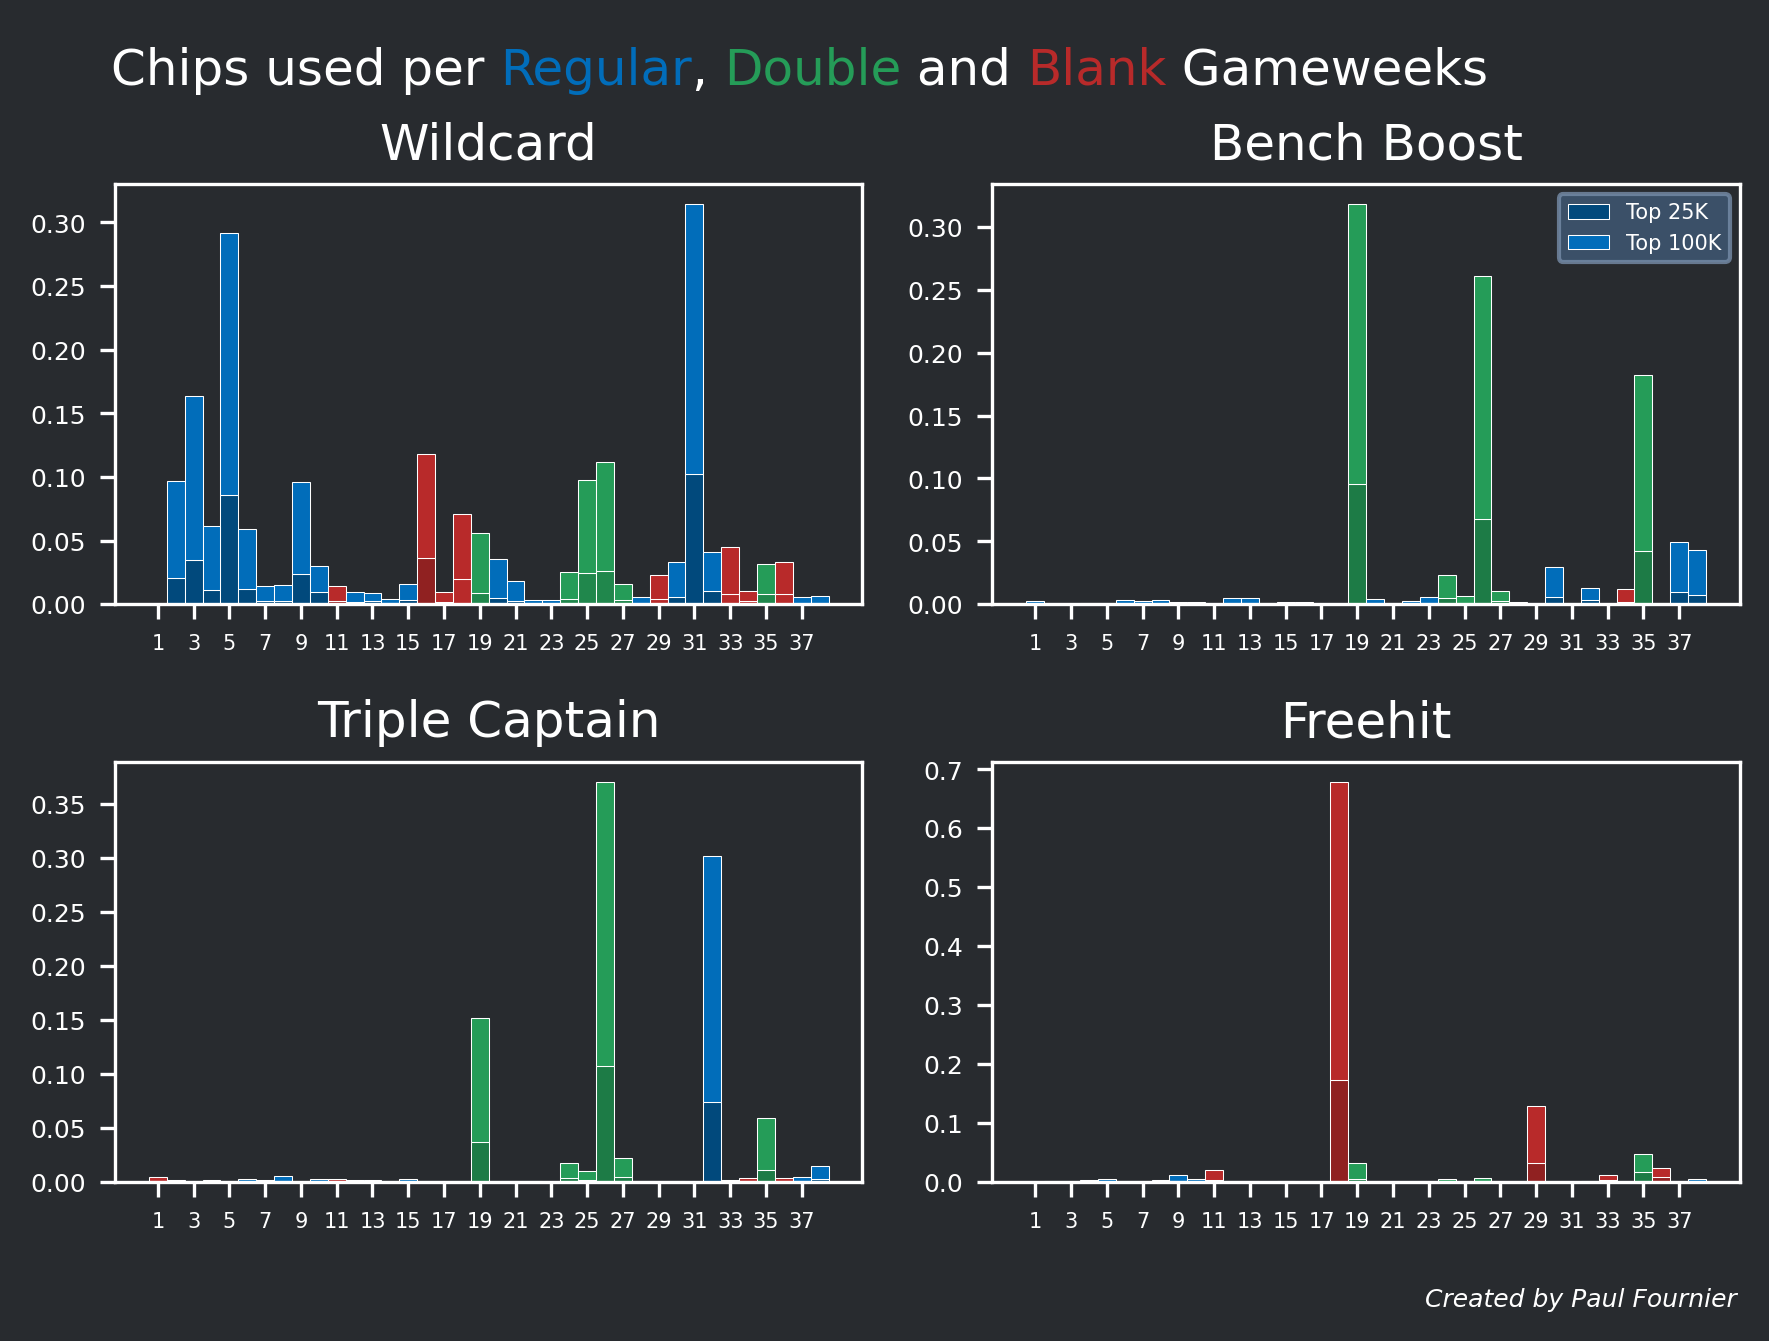

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 5
mpl.rcParams['ytick.labelsize'] = 6

fig, axs = plt.subplots(2, 2, tight_layout=True)
fig.set_facecolor(background)
axs[0, 0].patch.set_alpha(0)
axs[0, 1].patch.set_alpha(0)
axs[1, 0].patch.set_alpha(0)
axs[1, 1].patch.set_alpha(0)

_, _, patches = axs[0, 0].hist(
    [chips['wildcard_2'].loc[:25000], chips['wildcard_2'].loc[25000:]], bins=np.arange(1, 40) - 0.5,
    label='2', stacked=True, density=True, color=['#01497c', '#016DBA'], edgecolor='w', linewidth=0.25, alpha=1)

for k, v in gw_type.items():
    if v == 'BGW':
        patches[0][k-1].set_color('#B82A2A')
        patches[0][k-1].set_edgecolor('w')
        patches[1][k-1].set_color('#B82A2A')
        patches[1][k-1].set_edgecolor('w')
    elif v == 'DGW':
        patches[0][k-1].set_color('#20874C')
        patches[0][k-1].set_edgecolor('w')
        patches[1][k-1].set_color('#259C58')
        patches[1][k-1].set_edgecolor('w')

_, _, patches = axs[0, 0].hist(
    [chips['wildcard_1'].loc[:25000], chips['wildcard_1'].loc[25000:]], bins=np.arange(1, 40) - 0.5,
    label='1', stacked=True, density=True, color=['#01497c', '#016DBA'], edgecolor='w', linewidth=0.25, alpha=1)
axs[0, 0].title.set_text('Wildcard')
axs[0, 0].set_xticks(np.arange(1, 39, 2), minor=False)

for k, v in gw_type.items():
    if v == 'BGW':
        patches[0][k-1].set_color('#902121')
        patches[0][k-1].set_edgecolor('w')
        patches[1][k-1].set_color('#B82A2A')
        patches[1][k-1].set_edgecolor('w')
    elif v == 'DGW':
        patches[0][k-1].set_color('#1D7B46')
        patches[0][k-1].set_edgecolor('w')
        patches[1][k-1].set_color('#259C58')
        patches[1][k-1].set_edgecolor('w')

_, _, patches = axs[0, 1].hist(
    [chips['bboost'].loc[:25000], chips['bboost'].loc[25000:]], bins=np.arange(1, 40) - 0.5,
    stacked=True, density=True, color=['#01497c', '#016DBA'], edgecolor='w', linewidth=0.25, alpha=1)
axs[0, 1].title.set_text('Bench Boost')
axs[0, 1].set_xticks(np.arange(1, 39, 2), minor=False)

for k, v in gw_type.items():
    if k == 1: # Skip for legend color
        continue
    if v == 'BGW':
        patches[0][k-1].set_color('#902121')
        patches[0][k-1].set_edgecolor('w')
        patches[1][k-1].set_color('#B82A2A')
        patches[1][k-1].set_edgecolor('w')
    elif v == 'DGW':
        patches[0][k-1].set_color('#1D7B46')
        patches[0][k-1].set_edgecolor('w')
        patches[1][k-1].set_color('#259C58')
        patches[1][k-1].set_edgecolor('w')

legend = axs[0, 1].legend(prop={'size': 5}, labels=['Top 25K', 'Top 100K'], frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('#415A77')
frame.set_edgecolor('#778DA9')

_, _, patches = axs[1, 0].hist(
    [chips['threexc'].loc[:25000], chips['threexc'].loc[25000:]], bins=np.arange(1, 40) - 0.5,
    stacked=True, density=True, color=['#01497c', '#016DBA'], edgecolor='w', linewidth=0.25, alpha=1)
axs[1, 0].title.set_text('Triple Captain')
axs[1, 0].set_xticks(np.arange(1, 39, 2), minor=False)

for k, v in gw_type.items():
    if v == 'BGW':
        patches[0][k-1].set_color('#902121')
        patches[0][k-1].set_edgecolor('w')
        patches[1][k-1].set_color('#B82A2A')
        patches[1][k-1].set_edgecolor('w') 
    elif v == 'DGW':
        patches[0][k-1].set_color('#1D7B46')
        patches[0][k-1].set_edgecolor('w')
        patches[1][k-1].set_color('#259C58')
        patches[1][k-1].set_edgecolor('w') 

_, _, patches = axs[1, 1].hist(
    [chips['freehit'].loc[:25000], chips['freehit'].loc[25000:]], bins=np.arange(1, 40) - 0.5,
    stacked=True, density=True, color=['#01497c', '#016DBA'], edgecolor='w', linewidth=0.25, alpha=1)
axs[1, 1].title.set_text('Freehit')
axs[1, 1].set_xticks(np.arange(1, 39, 2), minor=False)

for k, v in gw_type.items():
    if v == 'BGW':
        patches[0][k-1].set_color('#902121')
        patches[0][k-1].set_edgecolor('w')
        patches[1][k-1].set_color('#B82A2A')
        patches[1][k-1].set_edgecolor('w')
    elif v == 'DGW':
        patches[0][k-1].set_color('#1D7B46')
        patches[0][k-1].set_edgecolor('w')
        patches[1][k-1].set_color('#259C58')
        patches[1][k-1].set_edgecolor('w')

fig_text(x=0.07, y=1.025,
        s="Chips used per <Regular>, <Double> and <Blank> Gameweeks",
        highlight_textprops=[
            {"color": '#016DBA'},
            {"color": '#259C58'},
            {"color": '#B82A2A'},
            ],
        fontweight="regular", fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

fig.text(0.8, -0.025, "Created by Paul Fournier", fontstyle="italic", fontsize=6, fontfamily=watermark_font, color=text_color)

plt.tight_layout()
plt.show()

The **Wildcard** chip is the most uniformely distributed. It does not seem to be used during a Bonus Gameweek and not even before major Bonus Gameweeks.

The **Bench Boost** is unsurpisingly mainly used in the Double Gameweeks. One thing to notice is that it is also mainly used in the second half of the season. In makes sense that once managers have accumulated extra funds to get a better bench, they activate the chip.

The **Triple Captain** is mainly used in either a Double or a Regular Gameweek. This seems to show that managers target a good fixture rather than a bonus GW. One thing to notice is that it is also mainly used in the second half of the season.

The **Freehit** is the biggest "get out of jail free card". It is mainly used in a Blank GW which suggests they are the mostly used to navigate the randomness of those fixtures. One thing to notice is that it is also mainly used in the second half of the season.

### Combinations

Now we can study if (and how) managers combine the benefits of the Chips.

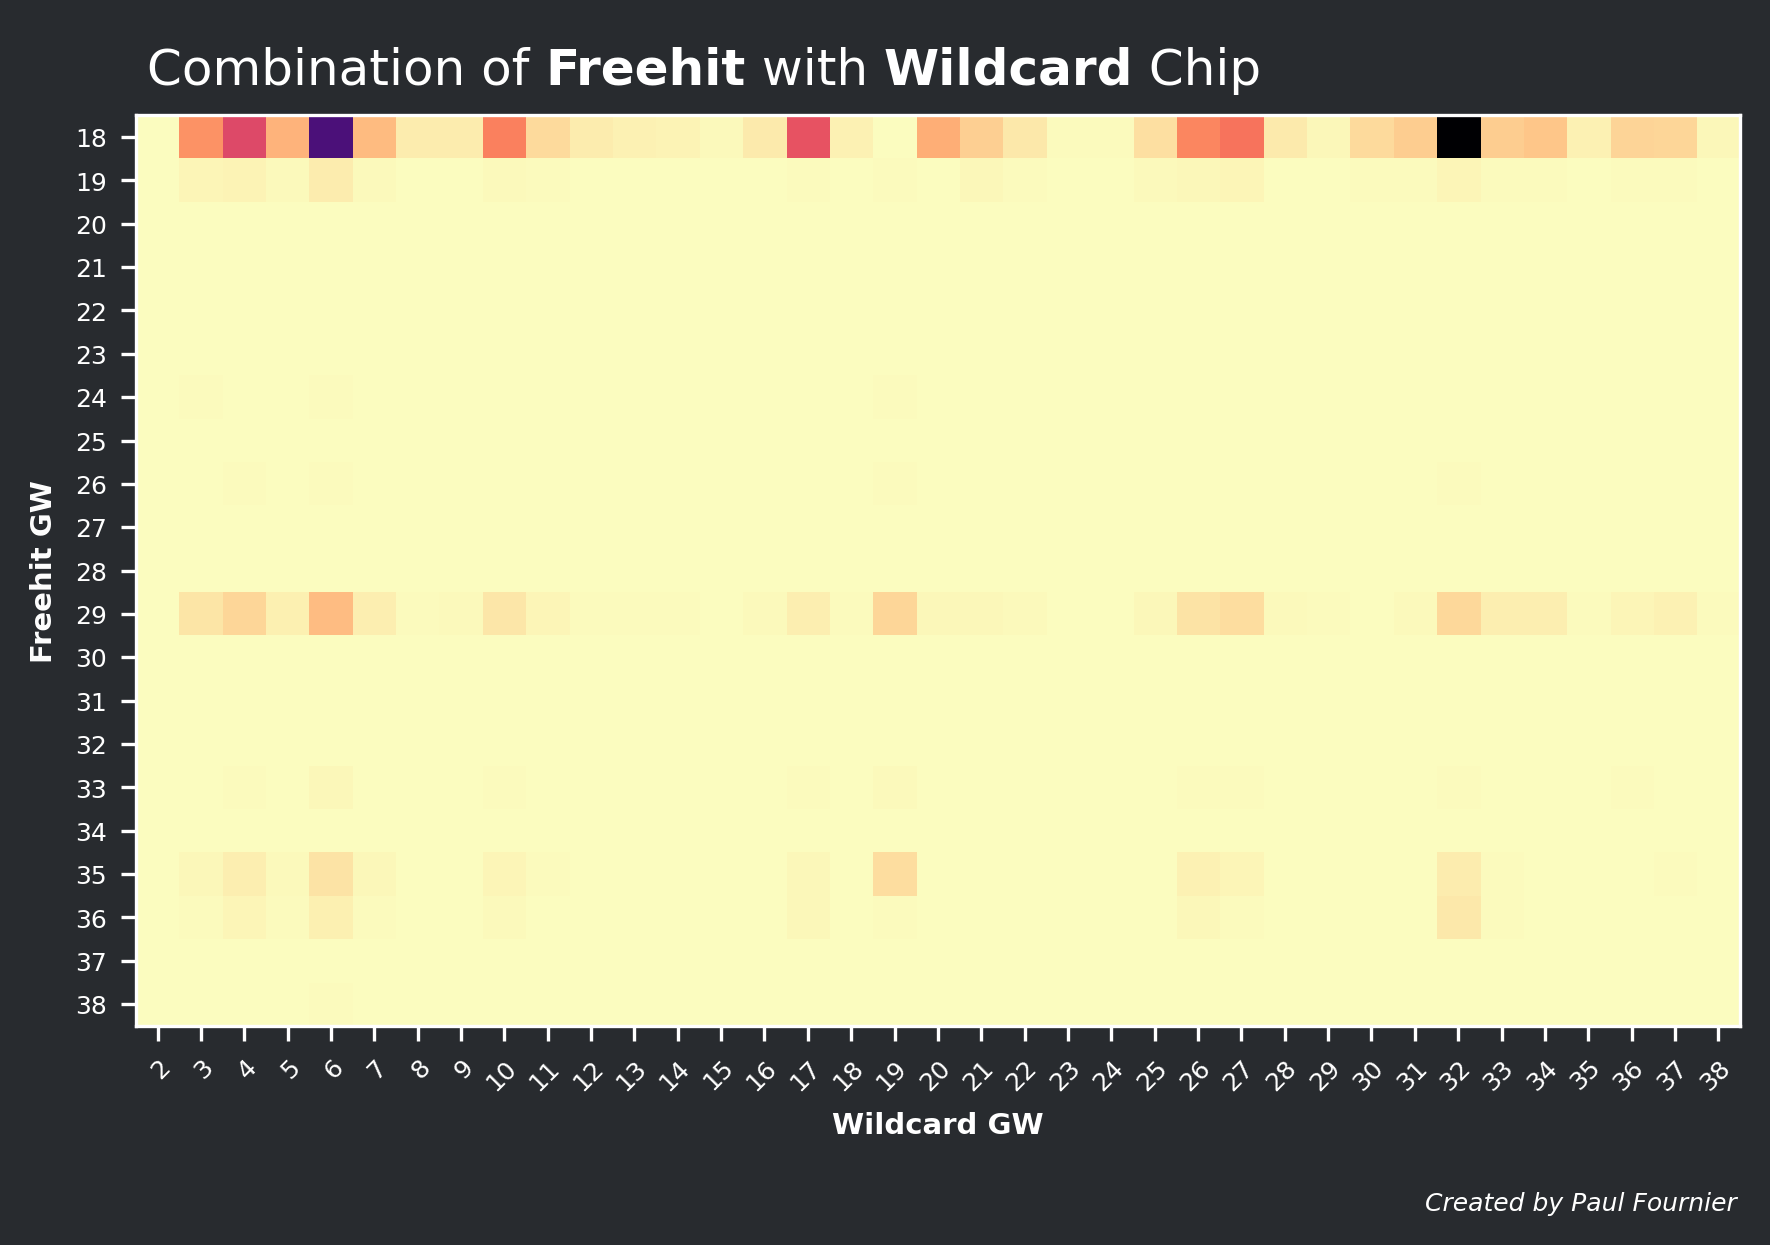

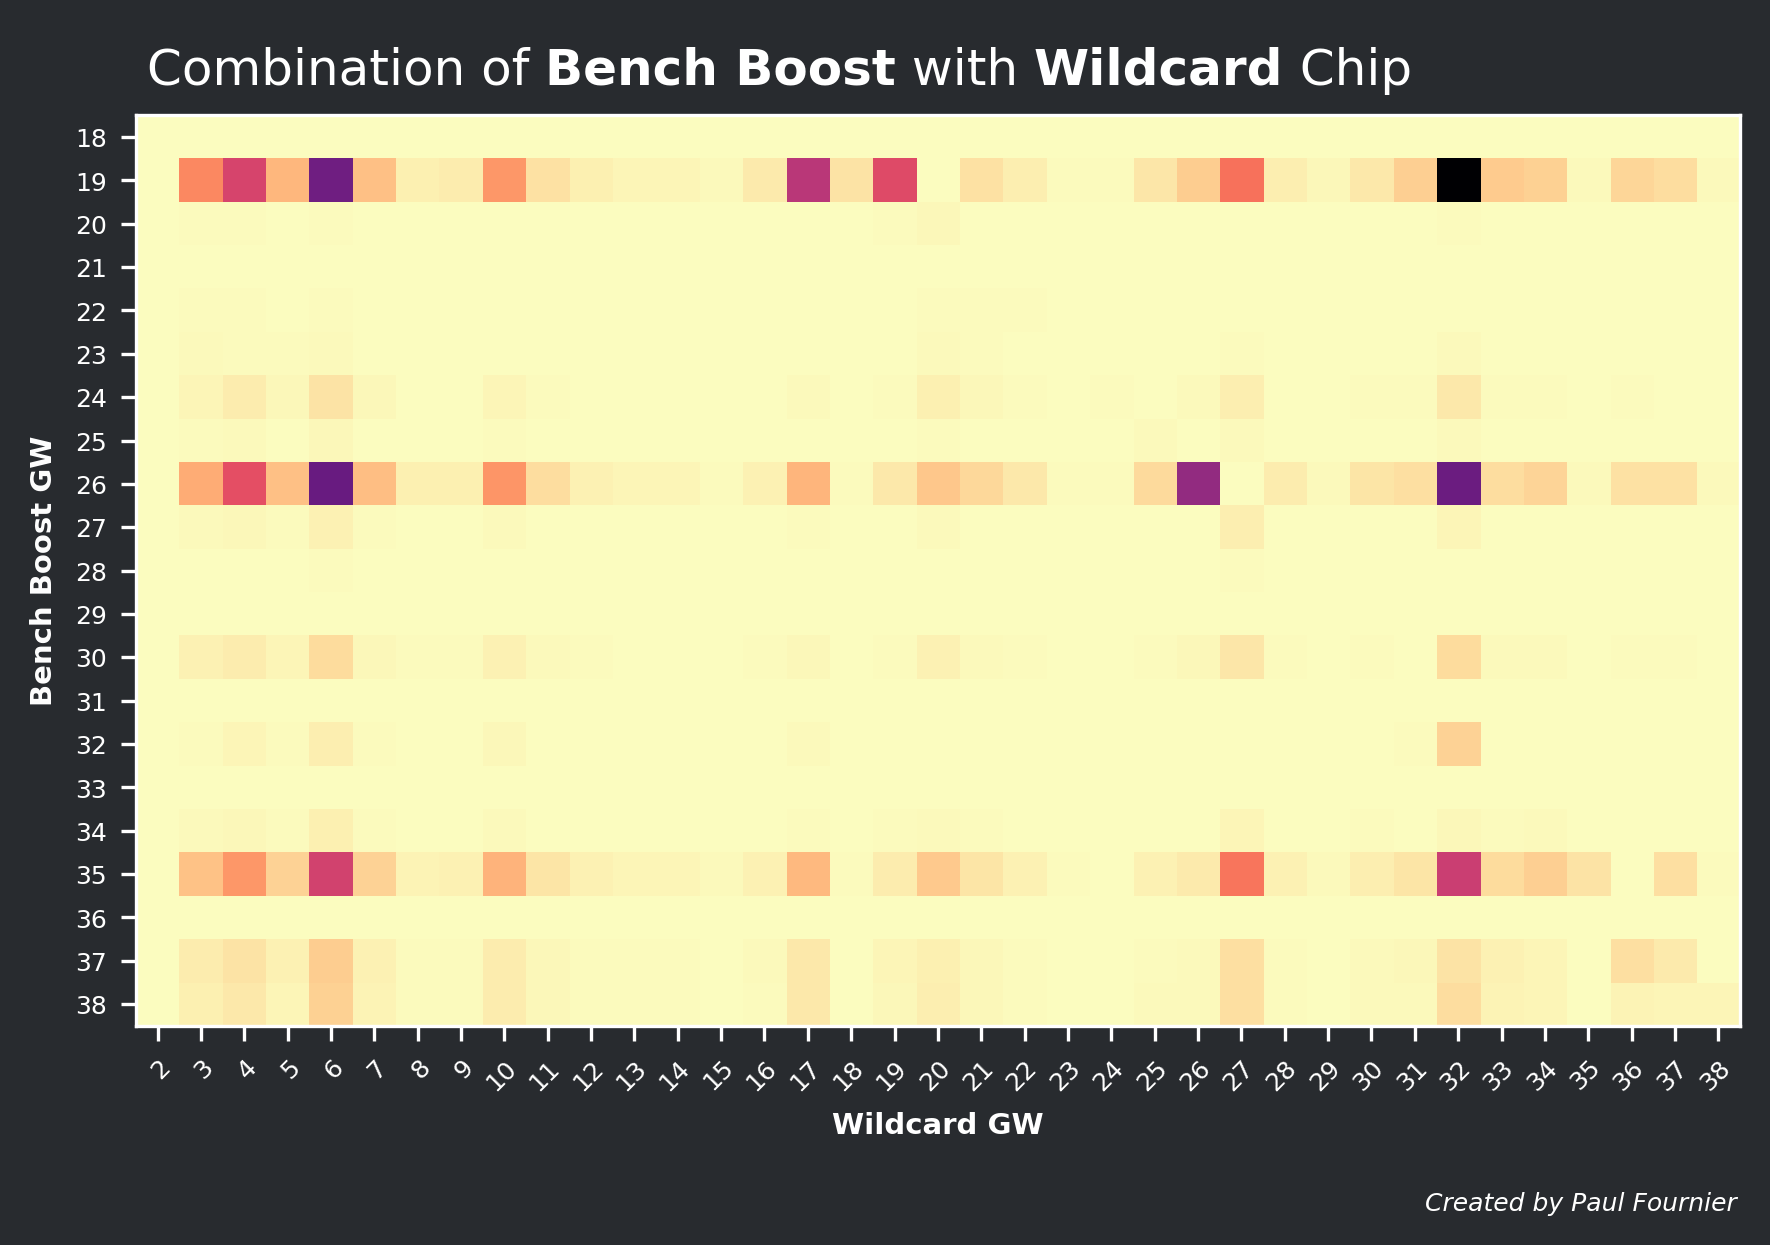

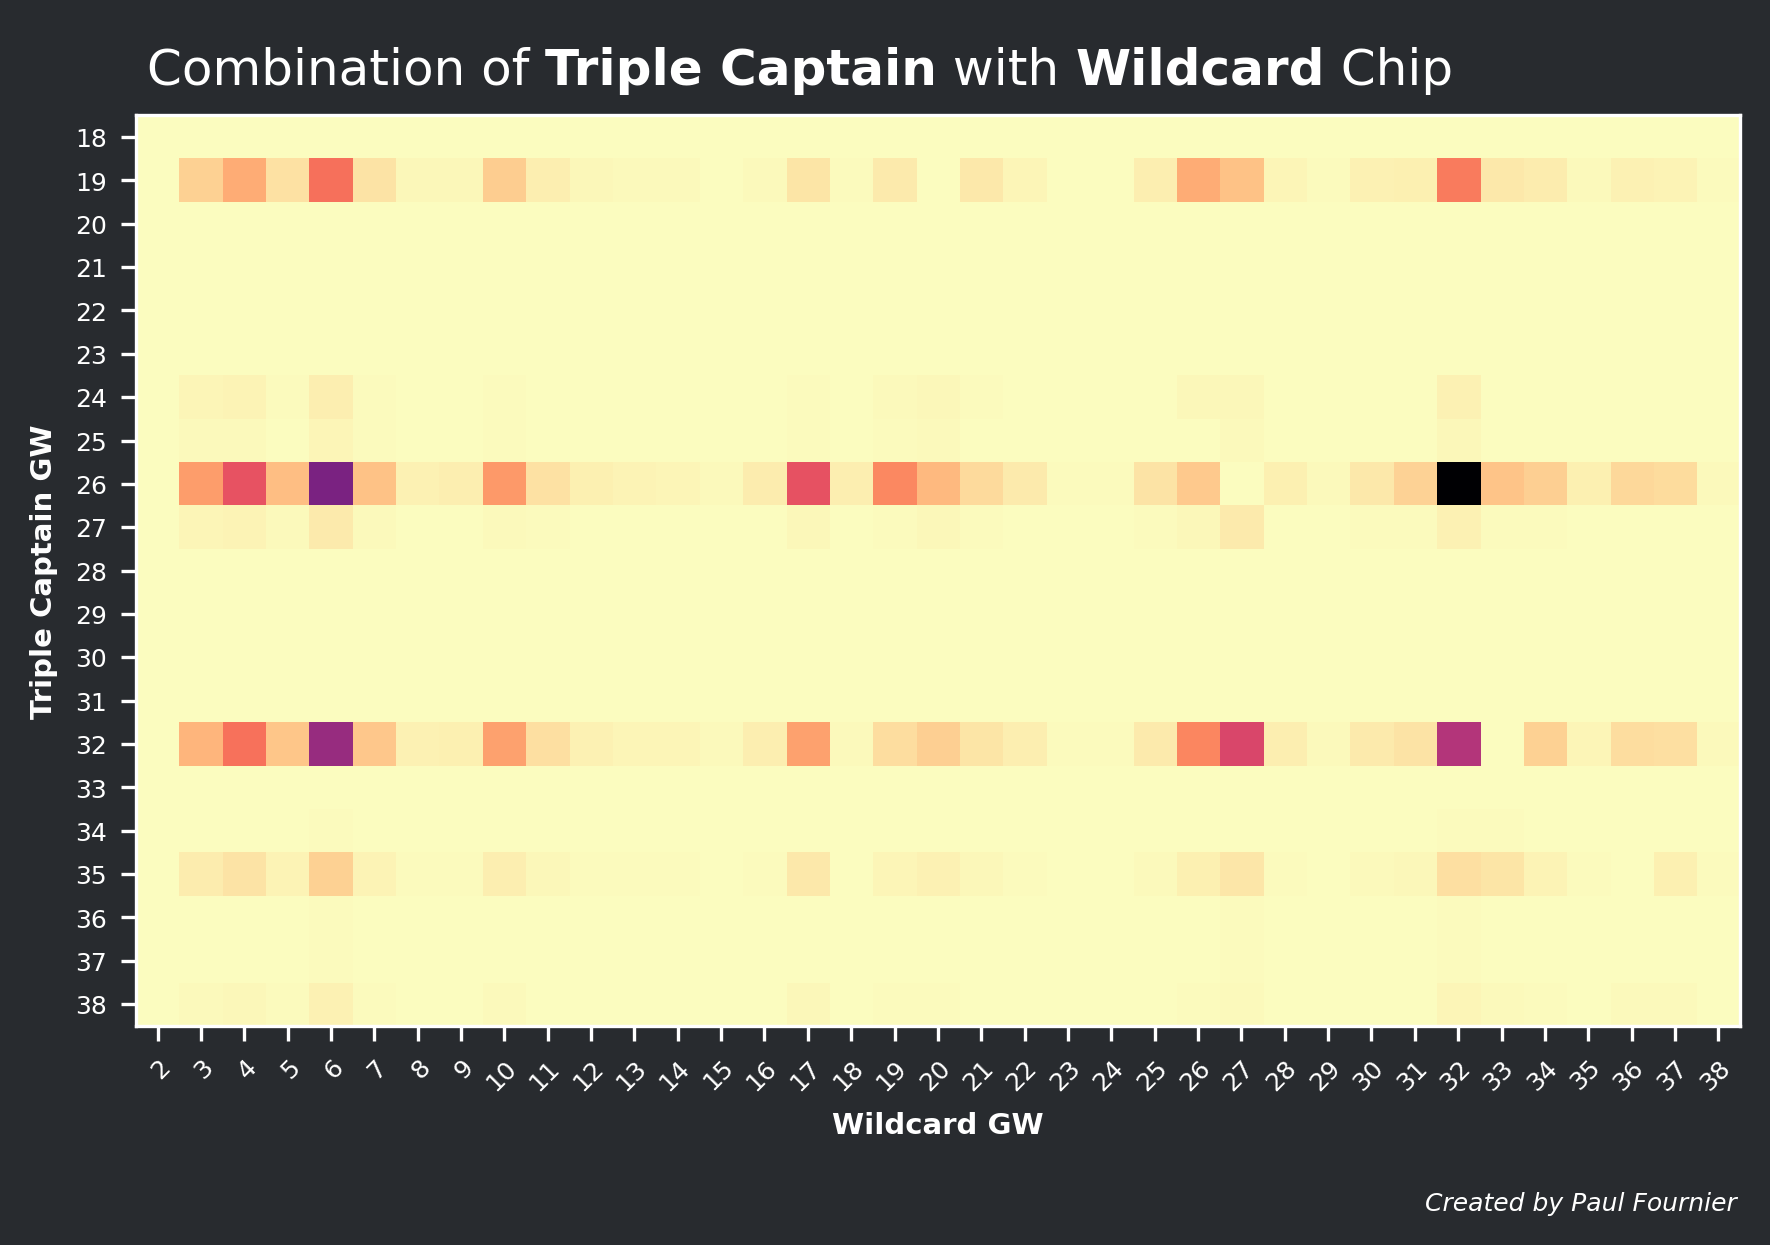

In [7]:
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

columns = ['freehit', 'bboost', 'threexc']
titles = ['Freehit', 'Bench Boost', 'Triple Captain']

col2 = 'wildcard_2'
title2 = 'Wildcard'

for col1, title1 in zip(columns, titles):
    heat = np.zeros((38-17, 37))
    for i in range(38-17):
        for j in range(1, 37):
            heat[i, j] = chips[(chips[col1] == i+1+17) & ((chips['wildcard_2'] == j+1) | (chips['wildcard_1'] == j+1))].shape[0]

    fig, ax = plt.subplots(tight_layout=True)
    fig.set_facecolor(background)
    ax.patch.set_alpha(0)

    fig.text(
        0.8, -0.02, "Created by Paul Fournier", fontstyle="italic",
        fontsize=6, fontfamily='DejaVu Sans', color=text_color)

    plt.imshow(heat, cmap='magma_r', interpolation='nearest')

    ax.set_xticks(np.arange(0, 37))
    ax.set_yticks(np.arange(0, 38-17))
    ax.set_xticklabels(np.arange(2, 39))
    ax.set_yticklabels(np.arange(18, 39))
    ax.set_xlabel(f"{title2} GW", fontfamily=title_font, fontweight="bold", fontsize=7, color=text_color)
    ax.set_ylabel(f"{title1} GW", fontfamily=title_font, fontweight="bold", fontsize=7, color=text_color)

    fig_text(x=0.09, y=0.95,
            s=f"Combination of <{title1}> with <{title2}> Chip",
            highlight_textprops=[
                {"fontweight": "bold"},
                {"fontweight": "bold"}
                ],
        fontweight="regular", fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

There is unfortunately not a real pattern for the combinations of chips.

### Points

Now let us study the bonus points the top managers were able to accumulate thanks to the chips. 

In [8]:
path = '../data/fpl_official/20-21/season/processed/'
all_points = (
    glob.glob(os.path.join(path, "points_[0-9][0-9][0-9][0-9][0-9].csv")) +
    glob.glob(os.path.join(path, "points_[0-9][0-9][0-9][0-9].csv")) +
    glob.glob(os.path.join(path, "points_100000.csv"))
)

points = (
    pd.read_csv(f, index_col=0)
    for f in all_points)
points = pd.concat(points)
points.sort_index(inplace=True)

In [9]:
def get_pts(gw):
    gw['wildcard_1'] = 0 if gw['wildcard_1'] == 0 else points.loc[int(gw.name), str(gw['wildcard_1'])]
    gw['freehit'] = 0 if gw['freehit'] == 0 else points.loc[int(gw.name), str(gw['freehit'])]
    gw['bboost'] = 0 if gw['bboost'] == 0 else points.loc[int(gw.name), str(gw['bboost'])]
    gw['wildcard_2'] = 0 if gw['wildcard_2'] == 0 else points.loc[int(gw.name), str(gw['wildcard_2'])]
    gw['threexc'] = 0 if gw['threexc'] == 0 else points.loc[int(gw.name), str(gw['threexc'])]

    return gw

chips_pts = chips.copy()
chips_pts = chips_pts.apply(
    lambda row: get_pts(row),
    axis=1)

chips_pts.describe().iloc[1:]

,wildcard_1,freehit,bboost,wildcard_2,threexc
mean,61.096824,62.799252,102.532911,71.450088,87.364545
std,19.405459,20.864851,27.385398,21.006156,19.988175
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,51.000000,84.000000,57.000000,75.000000
50%,61.000000,56.000000,104.000000,68.000000,84.000000
75%,77.000000,66.000000,123.000000,81.000000,97.000000
max,144.000000,163.000000,193.000000,163.000000,179.000000


This table shows us the average number of points Top 100K Managers got on the Gameweek they used their chip in.

In [10]:
gw_avg = points.mean()

def get_pts_diff(gw):
    gw['wildcard_1'] = 0 if gw['wildcard_1'] == 0 else points.loc[int(gw.name), str(gw['wildcard_1'])] - gw_avg[str(gw['wildcard_1'])]
    gw['freehit'] = 0 if gw['freehit'] == 0 else points.loc[int(gw.name), str(gw['freehit'])] - gw_avg[str(gw['freehit'])]
    gw['bboost'] = 0 if gw['bboost'] == 0 else points.loc[int(gw.name), str(gw['bboost'])] - gw_avg[str(gw['bboost'])]
    gw['wildcard_2'] = 0 if gw['wildcard_2'] == 0 else points.loc[int(gw.name), str(gw['wildcard_2'])] - gw_avg[str(gw['wildcard_2'])]
    gw['threexc'] = 0 if gw['threexc'] == 0 else points.loc[int(gw.name), str(gw['threexc'])] - gw_avg[str(gw['threexc'])]

    return gw

chips_pts_diff = chips.copy()
chips_pts_diff = chips_pts_diff.apply(
    lambda row: get_pts_diff(row),
    axis=1)

chips_pts_diff.describe().iloc[1:]

,wildcard_1,freehit,bboost,wildcard_2,threexc
mean,2.021761,6.238430,10.419357,4.303382,3.584643
std,10.528304,9.198464,14.896157,10.298246,12.927266
min,-44.000000,-40.000000,-52.000000,-49.000000,-58.000000
25%,-5.000000,0.000000,0.000000,-2.000000,-4.000000
50%,1.000000,5.000000,10.000000,4.000000,4.000000
75%,10.000000,10.000000,20.000000,11.000000,12.000000
max,78.000000,54.000000,76.000000,69.000000,80.000000


This table shows us the average number of points (above the Gameweek average), Top 100K Managers got on the Gameweek they used their chip in. Whilst it might not be fair to compare theses scores with only Top 100K Managers, we can already note two things. The **Freehit**, the **Triple Captain** seem to slightly impact the gameweek score differential on average. This might be due to the fact that most managers used those chips on the same GWs. The distributions plotted above are the least uniform ones. Yet the **Bench Boost** chip yielded an extra dozen points for the managers on average. The second thing we can note is that the **Wildcard** chip is regarded as the most powerfull one yet it is the one that yielded the least amount of extra point. A better estimate of the bonus generated by the chip would be to evaluate the points for the following GWs as well.

In [11]:
def get_discounted_pts(gw):
    gw['wc'] = points.loc[int(gw.name), str(gw['gw'])] - gw_avg[str(gw['gw'])]
    gw['next_1'] = points.loc[int(gw.name), str(gw['gw']+1)] - gw_avg[str(gw['gw']+1)] if gw['gw']+1 < 38 else 0
    gw['next_2'] = points.loc[int(gw.name), str(gw['gw']+2)] - gw_avg[str(gw['gw']+2)] if gw['gw']+2 < 38 else 0
    gw['next_3'] = points.loc[int(gw.name), str(gw['gw']+3)] - gw_avg[str(gw['gw']+3)] if gw['gw']+3 < 38 else 0

    return gw

In [12]:
discounted_wc1_pts = pd.DataFrame(columns=['wc', 'next_1', 'next_2', 'next_3'], index=np.arange(0, 5000))
discounted_wc1_pts.loc[:, 'gw'] = chips.loc[:, 'wildcard_1']
discounted_wc1_pts = discounted_wc1_pts.apply(
    lambda row: get_discounted_pts(row) if row['gw'] != 0 else 0,
    axis=1)
discounted_wc1_pts.drop(['gw'], axis=1, inplace=True)
discounted_wc1_pts.describe().iloc[1:]

,wc,next_1,next_2,next_3
mean,5.938289,0.805119,4.609808,2.374872
std,10.386937,10.196823,9.431326,10.466170
min,-32.698268,-36.018911,-32.018911,-45.742550
25%,-1.200208,-6.662466,-1.000490,-4.289572
50%,6.946828,0.337534,4.965399,1.710428
75%,13.946828,7.337534,10.753780,8.710428
max,53.408586,53.981089,44.337534,53.257450


In [13]:
gamma = 0.75
wc_gain = discounted_wc1_pts.mean()
wc_gain['wc'] + gamma * wc_gain['next_1'] + (gamma*gamma) * wc_gain['next_2'] + (gamma*gamma*gamma) * wc_gain['next_3']

10.137044339961102

In [14]:
discounted_wc2_pts = pd.DataFrame(columns=['wc', 'next_1', 'next_2', 'next_3'], index=np.arange(0, 5000))
discounted_wc2_pts.loc[:, 'gw'] = chips.loc[:, 'wildcard_2']
discounted_wc2_pts = discounted_wc2_pts.apply(
    lambda row: get_discounted_pts(row) if row['gw'] != 0 else 0,
    axis=1)
discounted_wc2_pts.drop(['gw'], axis=1, inplace=True)
discounted_wc2_pts.describe().iloc[1:]

,wc,next_1,next_2,next_3
mean,8.032946,9.235097,4.483331,1.090008
std,9.938756,12.363063,10.140459,10.379806
min,-29.392456,-28.034601,-35.322063,-35.322063
25%,1.332713,1.466926,-1.523741,-5.291652
50%,8.027891,6.889136,3.421947,0.000000
75%,14.511640,15.438928,10.332013,6.708348
max,45.105774,61.257450,57.257450,49.677937


In [15]:
wc_gain = discounted_wc2_pts.mean()
wc_gain['wc'] + gamma * wc_gain['next_1'] + (gamma*gamma) * wc_gain['next_2'] + (gamma*gamma*gamma) * wc_gain['next_3']

17.94099001103794

Analysing the **Wildcard** chip over a horizon of 4 gameweeks demonstrates the value of this Chip. Using a discount factor of 75%, we assume that 75% of the next GW's points are due to the wildcard transfers. Note that this is quite an arbitrary value.

### Team Value

The data I scrapped from the API does not contain gameweek-wise team value and money in the bank. So I approximate it using enf-of-gameweek player value.

In [16]:
path = '../data/fpl_official/20-21/season/processed/'
all_value = (
    glob.glob(os.path.join(path, "bench_value_[0-9][0-9][0-9][0-9].csv")) +
    glob.glob(os.path.join(path, "bench_value_[0-9][0-9][0-9][0-9][0-9].csv")) + 
    glob.glob(os.path.join(path, "bench_value_100000.csv"))
)

bench_value = (
    pd.read_csv(f, index_col=0)
    for f in all_value)
bench_value = pd.concat(bench_value)
bench_value.sort_index(inplace=True)

all_value = (
    glob.glob(os.path.join(path, "team_value_[0-9][0-9][0-9][0-9].csv")) +
    glob.glob(os.path.join(path, "team_value_[0-9][0-9][0-9][0-9][0-9].csv")) + 
    glob.glob(os.path.join(path, "team_value_100000.csv"))
)

team_value = (
    pd.read_csv(f, index_col=0)
    for f in all_value)
team_value = pd.concat(team_value)
team_value.sort_index(inplace=True)

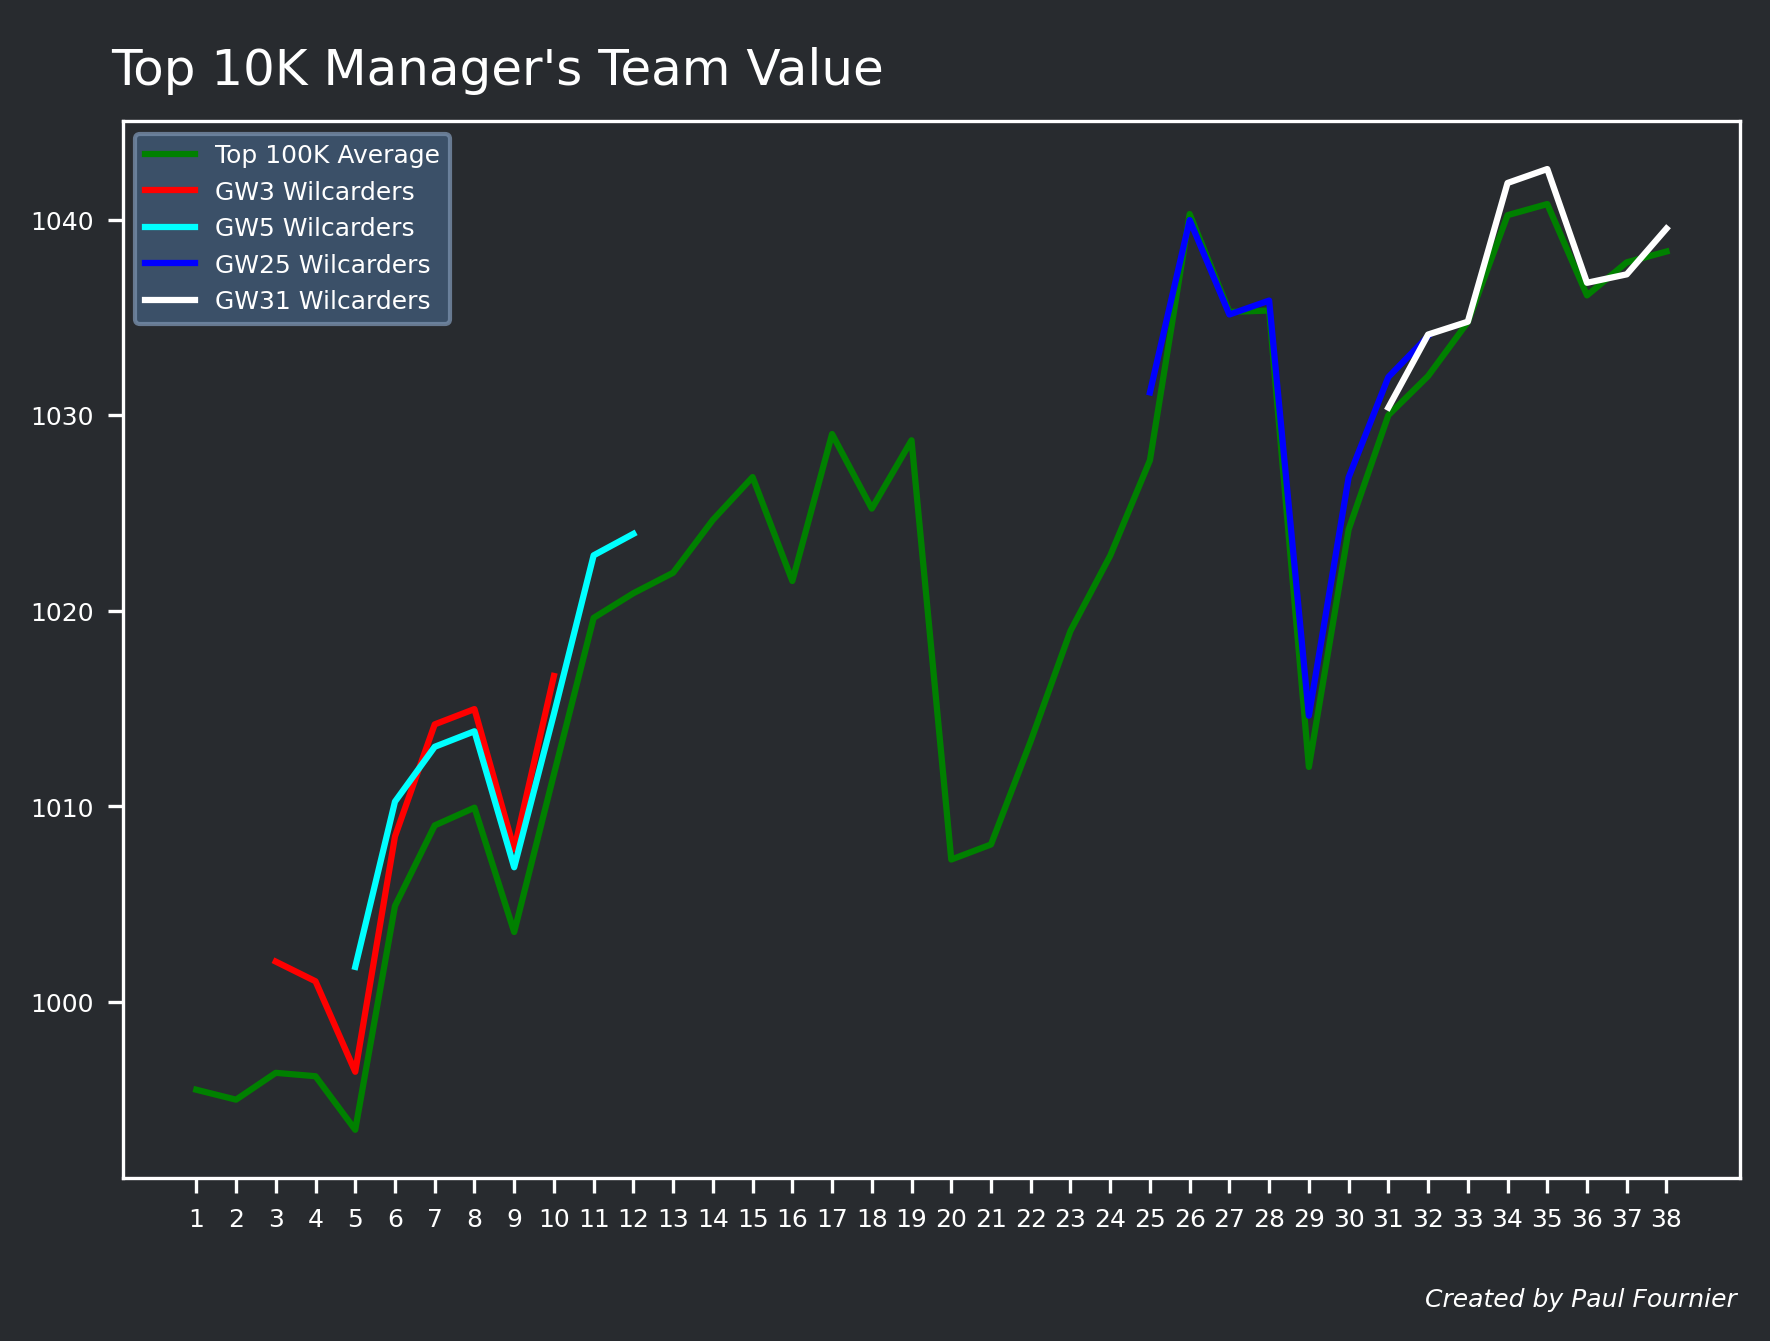

In [25]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

horizon=8
ax.plot(np.arange(1, 39), np.mean(team_value), color='g')
gw = 3; ax.plot(np.arange(gw, gw+horizon), np.mean(team_value[(chips['wildcard_1'] == 3)])[gw-1: gw+horizon-1], color='r')
gw = 5; ax.plot(np.arange(gw, gw+horizon), np.mean(team_value[(chips['wildcard_1'] == 5)])[gw-1: gw+horizon-1], color='cyan')
gw = 25; ax.plot(np.arange(gw, gw+horizon), np.mean(team_value[(chips['wildcard_2'] == 25)])[gw-1: gw+horizon-1], color='b')
gw = 31; ax.plot(np.arange(gw, gw+horizon), np.mean(team_value[(chips['wildcard_2'] == 31)])[gw-1: gw+horizon-1], color='w')

legend = ax.legend(prop={'size': 6}, labels=['Top 100K Average', 'GW3 Wilcarders', 'GW5 Wilcarders', 'GW25 Wilcarders', 'GW31 Wilcarders'])
frame = legend.get_frame()
frame.set_facecolor('#415A77')
frame.set_edgecolor('#778DA9')

ax.set_xticks(np.arange(1, 39), minor=False)

fig_text(x=0.07, y=1.025,
        s="Top 10K Manager's Team Value",
        fontweight="regular", fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

fig.text(0.8, -0.025, "Created by Paul Fournier", fontstyle="italic", fontsize=6, fontfamily=watermark_font, color=text_color)
plt.show()

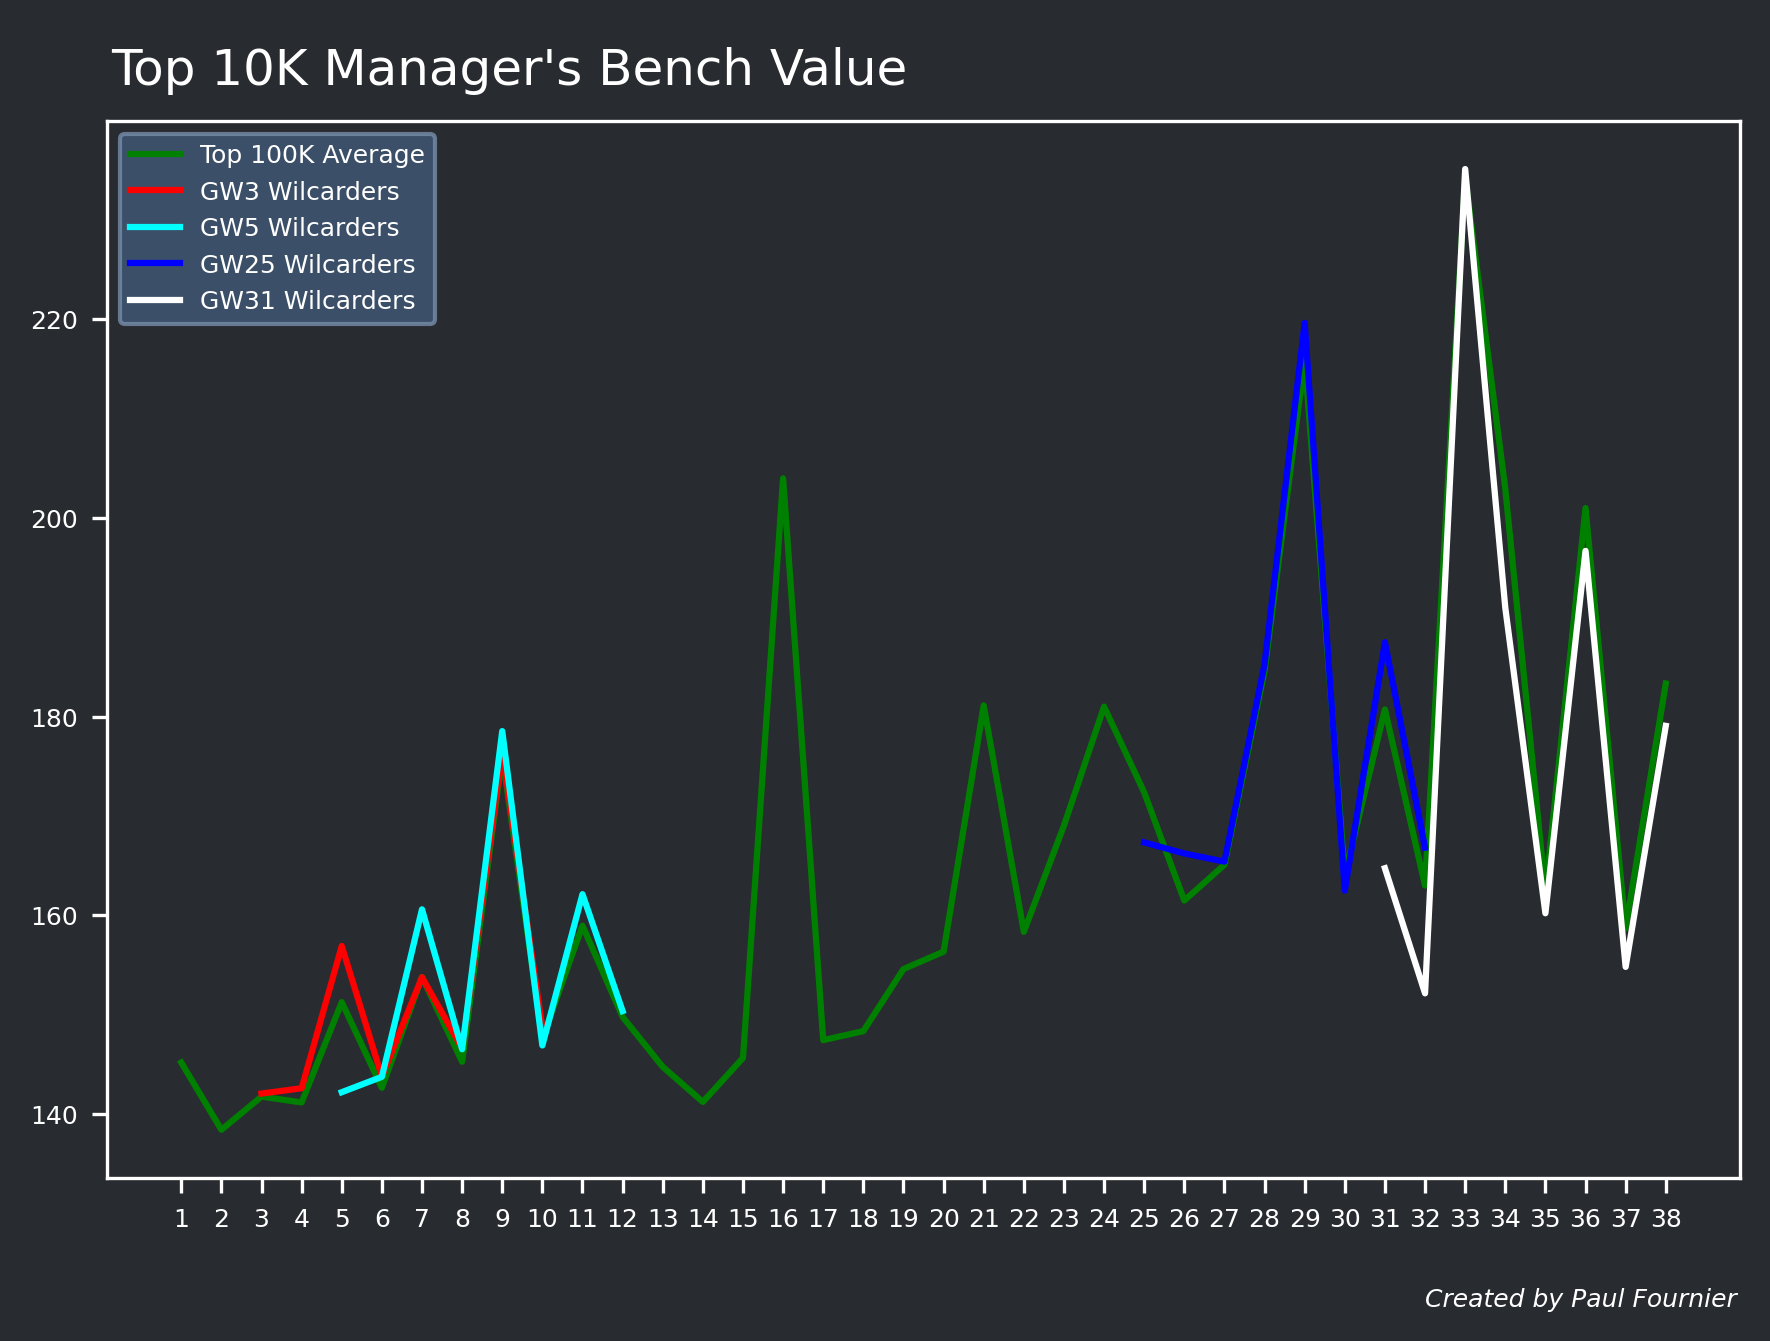

In [26]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

horizon=8
ax.plot(np.arange(1, 39), np.mean(bench_value), color='g')
gw = 3; ax.plot(np.arange(gw, gw+horizon), np.mean(bench_value[(chips['wildcard_1'] == 3)])[gw-1: gw+horizon-1], color='r')
gw = 5; ax.plot(np.arange(gw, gw+horizon), np.mean(bench_value[(chips['wildcard_1'] == 5)])[gw-1: gw+horizon-1], color='cyan')
gw = 25; ax.plot(np.arange(gw, gw+horizon), np.mean(bench_value[(chips['wildcard_2'] == 25)])[gw-1: gw+horizon-1], color='b')
gw = 31; ax.plot(np.arange(gw, gw+horizon), np.mean(bench_value[(chips['wildcard_2'] == 31)])[gw-1: gw+horizon-1], color='w')

legend = ax.legend(prop={'size': 6}, labels=['Top 100K Average', 'GW3 Wilcarders', 'GW5 Wilcarders', 'GW25 Wilcarders', 'GW31 Wilcarders'])
frame = legend.get_frame()
frame.set_facecolor('#415A77')
frame.set_edgecolor('#778DA9')
ax.set_xticks(np.arange(1, 39), minor=False)

fig_text(x=0.07, y=1.025,
        s="Top 10K Manager's Bench Value",
        fontweight="regular", fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

fig.text(0.8, -0.025, "Created by Paul Fournier", fontstyle="italic", fontsize=6, fontfamily=watermark_font, color=text_color)
plt.show()

It is very hard to draw definite conclusion from this noisy data. FPL managers tend to pro-actively transfer players early in the season to take advantage of price-changes.

In [19]:
wildcard_rank = chips.copy()
wildcard_rank = wildcard_rank[['wildcard_1']]
wildcard_rank.reset_index(level=0, inplace=True)
wildcard_rank.groupby('wildcard_1').mean().iloc[1:].round(2)

,index
wildcard_1,
2,52759.03
3,52981.40
4,55148.26
5,46658.29
6,53078.87
7,54996.99
8,53729.36
9,49849.18
10,45527.70


In [20]:
wildcard_rank = chips.copy()
wildcard_rank = wildcard_rank[['wildcard_2']]
wildcard_rank.reset_index(level=0, inplace=True)
wildcard_rank.groupby('wildcard_2').mean().iloc[1:].round(2)

,index
wildcard_2,
17,57807.04
18,48168.33
19,57090.27
20,57840.25
21,58933.59
22,61771.26
23,62533.74
24,55559.13
25,49318.02
